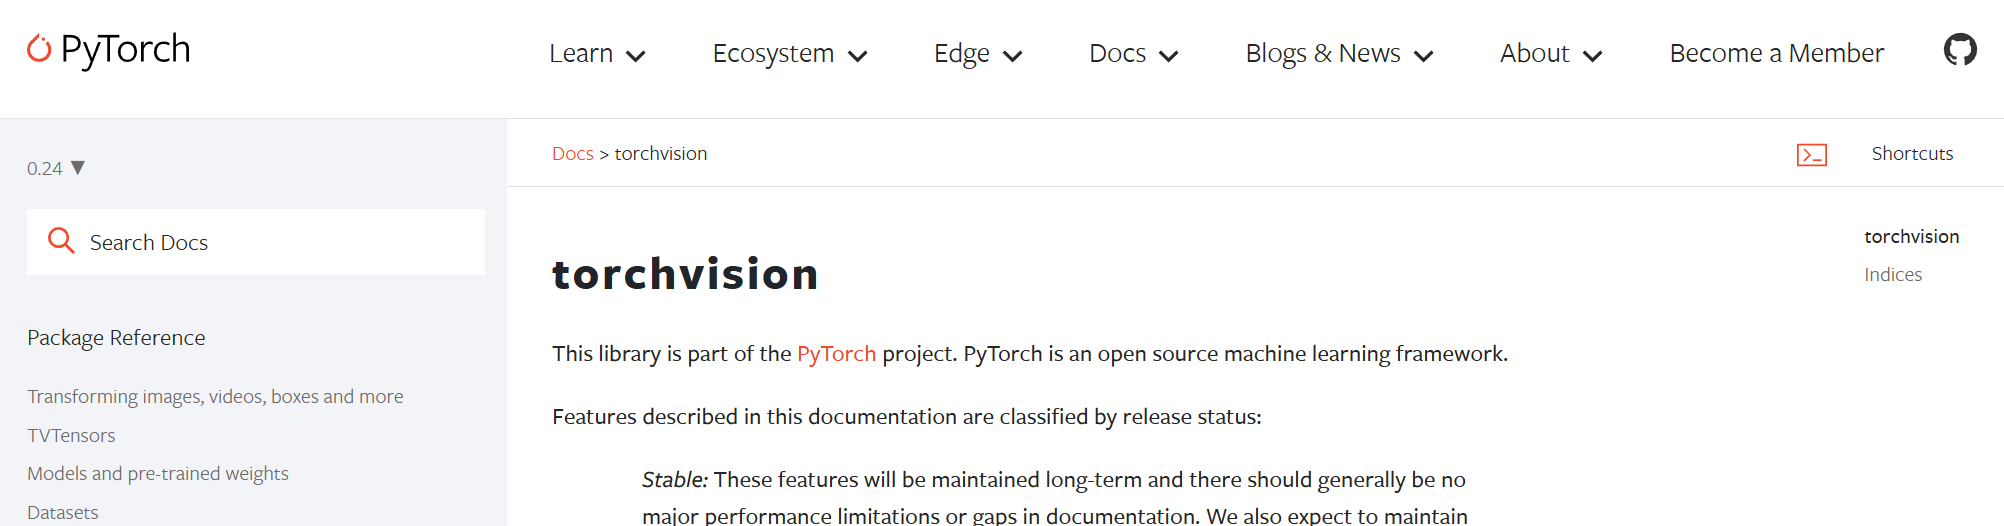

In [1]:
!nvidia-smi

Thu Nov  6 23:11:32 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 576.88                 Driver Version: 576.88         CUDA Version: 12.9     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 5070 ...  WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   45C    P8              3W /   40W |     126MiB /   8151MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
import torch
from torchvision import models

Каждый сверточный слой выступает фильтром, который сохраняет нужную информацию, но при этом изображение на входе в слой уменьшается в размере на выходе.

In [3]:
alexnet = models.AlexNet
alexnet

torchvision.models.alexnet.AlexNet

Данная сеть, без весов не будет работать правильно. Нужно либо обучить её, либо использовать эталонные веса.

Прямой проход - это прохождение входного сигнала (данных) через каждый из слоев (вход-выход-вход), до выходного сигнала.

In [4]:
resnet = models.resnet101(weights=True)
# resnet

c:\Users\Legion\anaconda3\envs\ods\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Предобработка изображений

In [5]:
from torchvision import transforms

preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

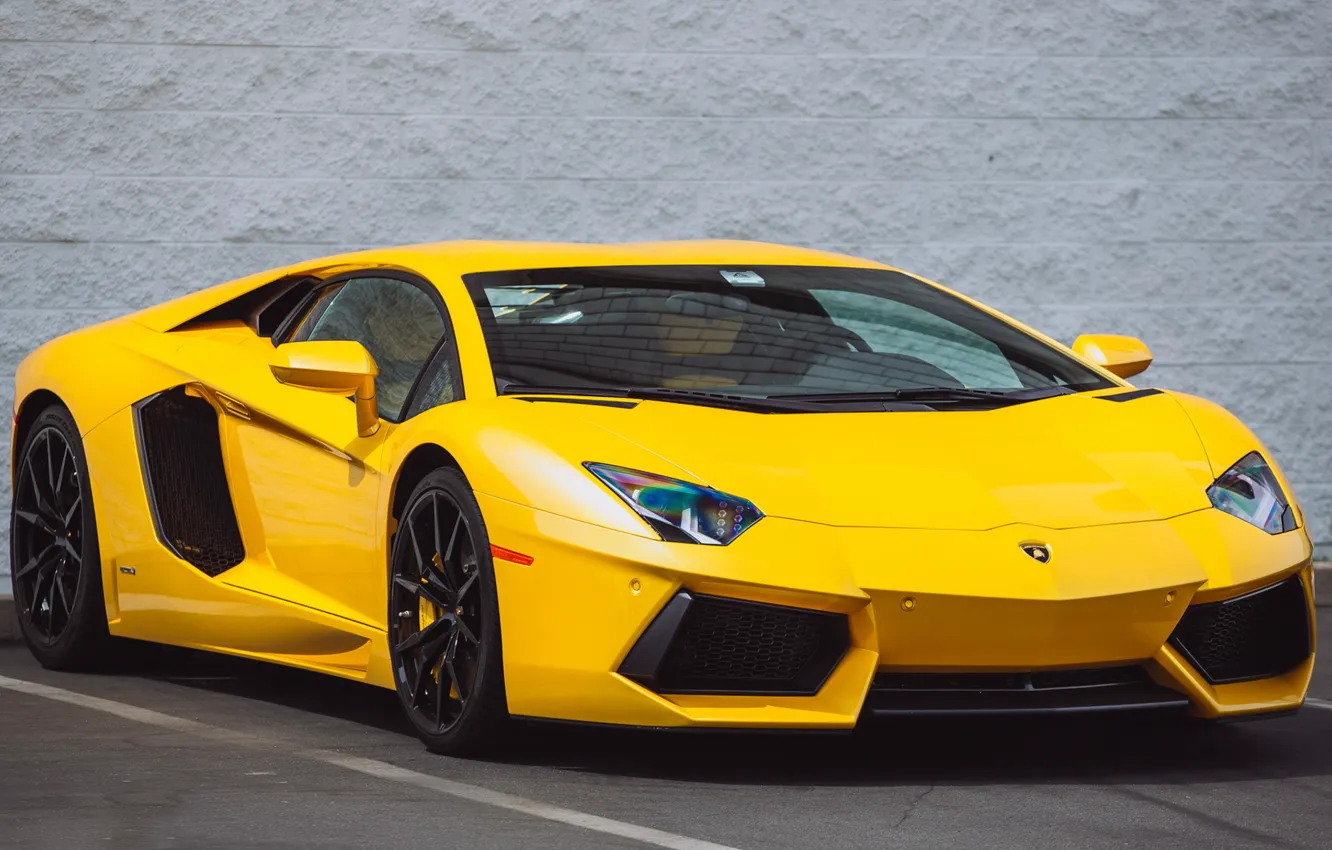

In [6]:
from PIL import Image

img = Image.open("../../images/lamborghini-aventador-yellow.webp")
img

In [7]:
img.show()  # Window with image

In [8]:
img_g = preprocess(img)
img_g.shape

torch.Size([3, 224, 224])

Вставим четвертую ось спереди

In [9]:
batch_g = torch.unsqueeze(img_g, 0)
batch_g.shape

torch.Size([1, 3, 224, 224])

Процесс выполнения обученной модели на новых данных в Deep Learning называется **инференсом (inference)**. Для выполнения инференса необходимо перевести сеть в режим eval. Без eval предобученные модели не сработают как надо.

In [10]:
resnet.eval()
out = resnet(batch_g)
out.shape

torch.Size([1, 1000])

In [11]:
# More natural way
out.argmax()

tensor(817)

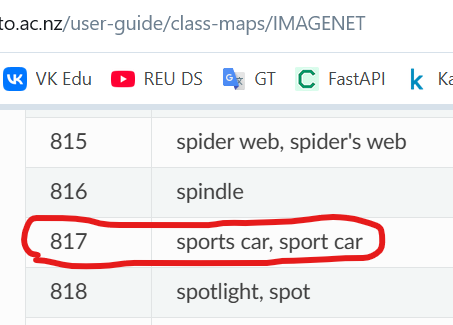

In [12]:
# Labels for the ImageNet
with open("../../data/ImageNet/imagenet_classes.txt") as file:
    labels = [line.strip() for line in file.readlines()]

In [13]:
value, index = torch.max(out, 1)
value, index

(tensor([17.1305], grad_fn=<MaxBackward0>), tensor([817]))

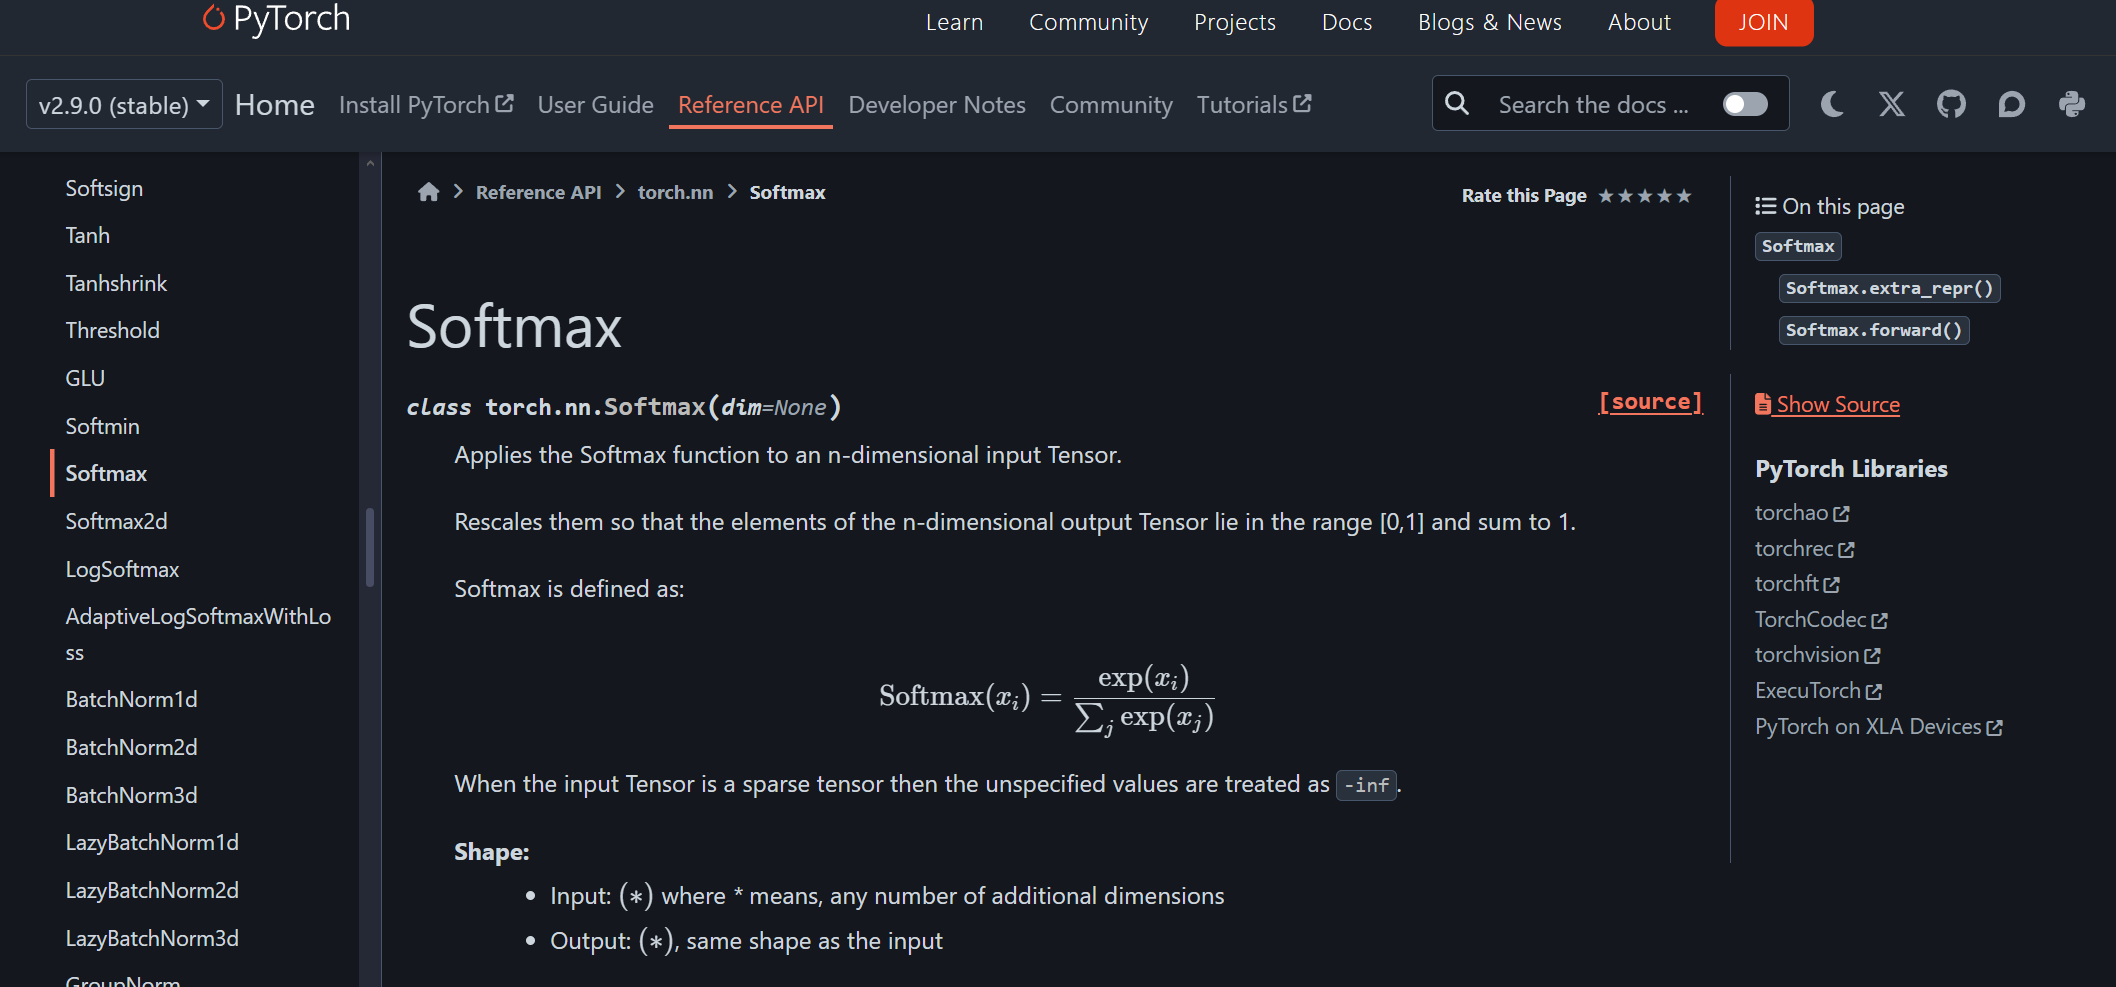

In [14]:
import torch.nn as nn 

percentage = nn.functional.softmax(input=out, dim=1)[0] * 100
print(f'Class: {labels[index]}, confidence: {percentage[index].item()}')

Class: sports car, sport car, confidence: 68.20145416259766


5 most probable classes for the picture

In [15]:
_, indexes = torch.sort(input=out, descending=True)
five_most_prob = indexes[0][:5]
[(labels[index], percentage[index].item()) for index in five_most_prob]

[('sports car, sport car', 68.20145416259766),
 ('racer, race car, racing car', 28.885196685791016),
 ('car wheel', 2.2966549396514893),
 ('grille, radiator grille', 0.20369958877563477),
 ('cab, hack, taxi, taxicab', 0.16059501469135284)]

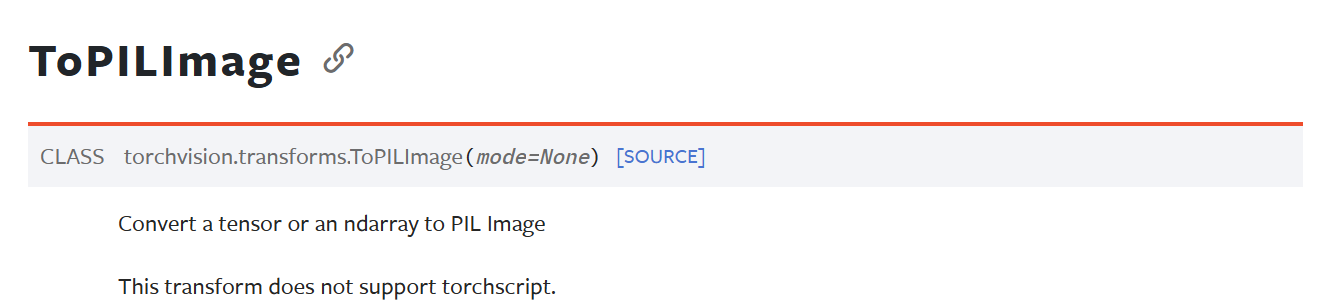
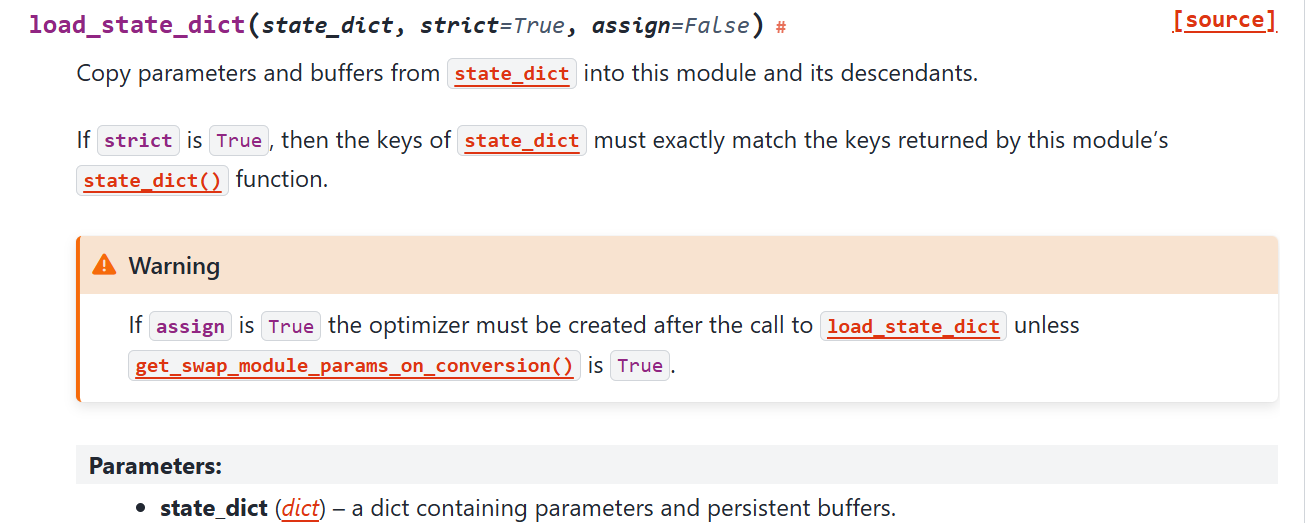

### Берем предобученный ResNet50 из Torch Hub

In [16]:
from torch import hub

resnet50_model = hub.load(repo_or_dir="pytorch/vision:main", model="resnet50", weights="ResNet50_Weights.IMAGENET1K_V1")
# resnet50_model

Using cache found in C:\Users\Legion/.cache\torch\hub\pytorch_vision_main


GAN (generative adversarial network) - порождающие состязательные сети. Их основная задача - это генерация синтетических изображений, в которых нельзя выявить подделку (отличия от оригинала).

GAN состоит из сети "художника"-генератора, который генерирует правдоподобные "подделки", начиная с произвольной стартовой точки (шум или входное изображение) и сети "эксперта"-дискриминатора, который определяет что изображение не настоящая и сообщает генератору какие ошибки он совершил при генерации.

Конечная цель генератора - "обмануть" дискриминатор и выдать поддельные ему изображения за настоящие, а дискриминатора обнаружить подделку и объяснить что не так генератору. Обе сети учатся на выходах друг друга и в конце концов дискриминатор не может отличить генерацию генератора от реального изображения.

**CycleGAN** состоит из двух генераторов и дискриминаторов.

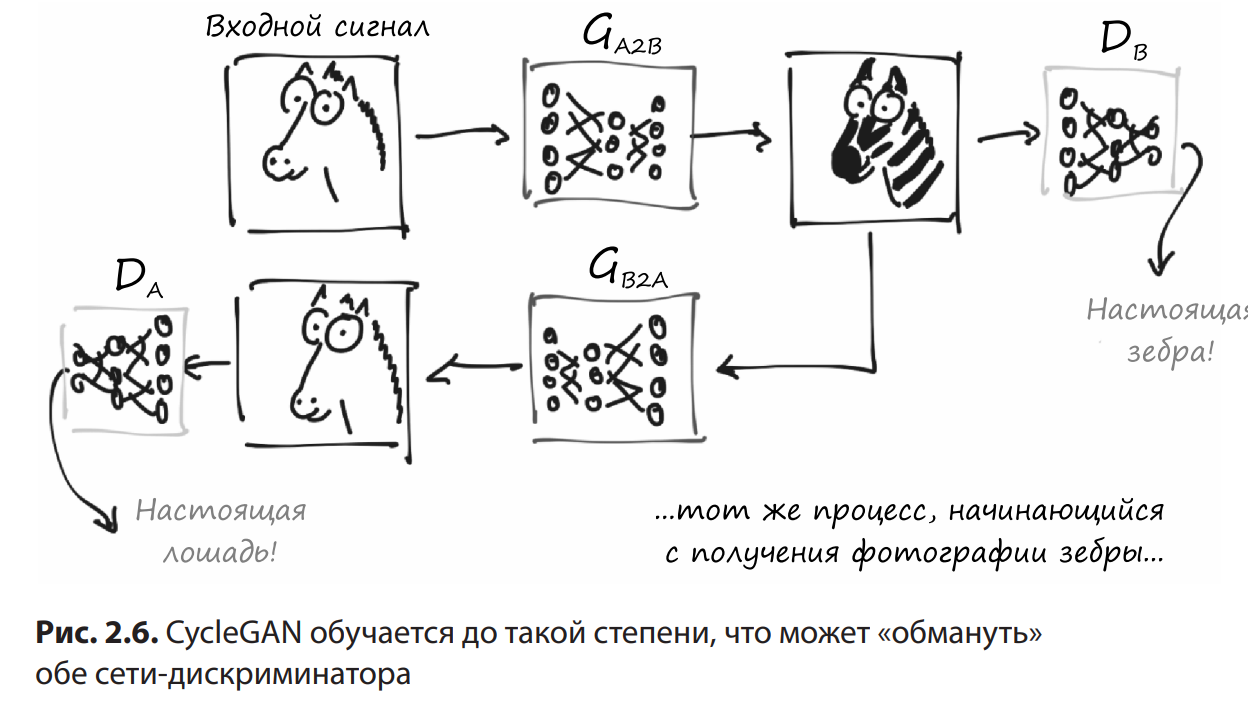

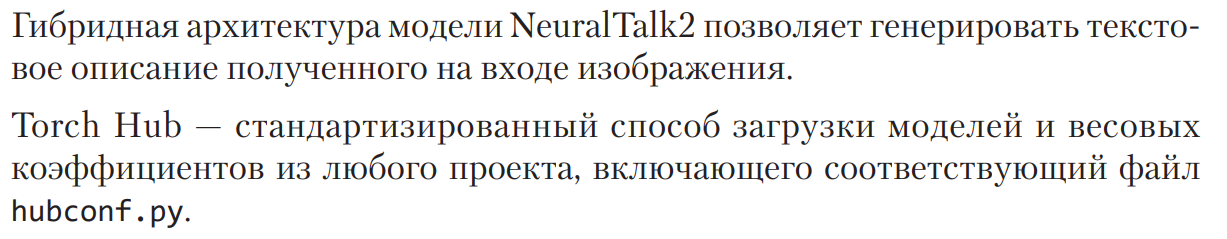